In [15]:
AbsRootDir = '/home/markus/src' 

In [16]:
# =============================================================================
# ##Step 1. Load Dataset
# =============================================================================

import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RawDataSetPath = AbsRootDir+r'/QCAD/Data/Examples/football_example.csv'

RawDataSet = pd.read_csv(RawDataSetPath, sep=",")

RawDataSet = RawDataSet.dropna()  #remove missing values

MyColList = ['Position1','Position2', 'Age', 'Matches', 'Starts','Mins','Goals', 'Assists']

MyContextList = ['Position1','Position2', 'Age', 'Matches', 'Starts','Mins']

MyBehaveList = ['Goals', 'Assists']

neighbour_value = 266

#### Step 2. Anomaly Detection
- Data Preprocessing 1 by scaling all behavioural attributes
- Data Preprocessing 2 by encoding categorical contextual attributes 
- Define QCAD
- Execute QCAD
- Save results


In [17]:
###############################################################################
## Step2.1. Data Preprocessing -> Scale all behavioural attributes
###############################################################################

from sklearn.preprocessing import MinMaxScaler
MyScaler = MinMaxScaler()
if len(MyBehaveList) > 0:
    RawDataSet[MyBehaveList] = MyScaler.fit_transform(RawDataSet[MyBehaveList])


In [22]:
###############################################################################
## Step2.2. Data Preprocessing -> Encode categorical contextual attributes 
###############################################################################

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
RawDataSet["Position1"] = label_encoder.fit_transform(RawDataSet["Position1"])
RawDataSet["Position2"] = label_encoder.fit_transform(RawDataSet["Position2"])

RawDataNoEncoding = pd.read_csv(RawDataSetPath, sep=",")



In [23]:
###############################################################################
## Step2.3. Define QCAD, which is also available in QCAD.py.
##          For completeness, we copy it here.
###############################################################################

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import percentile
import numbers


import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
#from skgarden import RandomForestQuantileRegressor
from quantile_forest import RandomForestQuantileRegressor


def QCAD(RawDataSet,
         MyColList,
         MyContextList,
         MyBehaveList,
         neighbour_value):
    """
    Parameters
    ----------
    RawDataSet : dataframe
        dataframe containing raw data.
    MyColList : list
        the list of all feature names.
    MyContextList : list
        the list of all contextual feature names.
    MyBehaveList : list
        the list of all behavioural feature names.
    neighbour_value : int
        the number of neighbours.

    Returns
    -------
    MyDataset : dataframe
        dataframe containing raw data and anomaly scores.
    distance_matrix : dataframe
        Gower's distance matrix between all objects.

    """

    ###############################################################################
    ##Step F1. set datasets
    ###############################################################################

    MyDataSet = RawDataSet[MyColList]
    MyContextDataSet = MyDataSet[MyContextList]

    ###############################################################################
    ##Step F2. find  neighbors in contextual space for each point
    ###############################################################################
    import gower
    from time import time
    t0 = time() # to record time 


    # calculate gower distance matrix
    MyContextDataSet = MyContextDataSet.astype(str)

    distance_matrix = gower.gower_matrix(MyContextDataSet)

    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(algorithm='brute', n_neighbors=neighbour_value, metric="precomputed").fit(distance_matrix)


    indices = knn.kneighbors(distance_matrix,return_distance=False)

    indices = pd.DataFrame(indices)

    indices['point_index'] = indices.index

    t1 = time()  # to record time 
    duration1 = round(t1 - t0, ndigits=4)
    print("matrix calculation processing time (s): ")
    print(duration1)

    ###############################################################################
    ##Step F3. calculate  anomaly  score in behavioral  space for each point
    ###############################################################################

    
    def QRF_score(ReferenceDataSet, MyColList, MyContextList, MyBehaveList, step_width, new_point_index):
        """
        
        Parameters
        ----------
        ReferenceDataSet : dataframe
            dataframe that contains the neighbours of an instance.
        MyColList : list
            the list of all feature names.
        MyContextList : list
            the list of all contextual feature names.
        MyBehaveList : list
            the list of all behavioural feature names.
        step_width : int
            int value used to specifiy the number of quantiles such that 100/step_width must be an int.
        new_point_index : int
            index of newly considered instance.

        Returns
        -------
        anomaly_behave : list
            list containing anomaly scores.
            
        """

        MyDataSet = ReferenceDataSet[MyColList]
        MyContextDataSet = MyDataSet[MyContextList]
        MyBehaveDataSet = MyDataSet[MyBehaveList]

        def QuantilePerCol(X_train, X_test, y_train, y_test, step_width =1):
            """

            Parameters
            ----------
            X_train : dataframe
                contextual feature values of the reference group.
            X_test : dataframe
                contextual feature values of the target object.
            y_train : dataframe
                behavioural feature values of the reference group.
            y_test : dataframe
                behavioural feature values of target object.
            step_width : int
                int value used to specifiy the number of quantiles uch that 100/step_width must be an int.

            Returns
            -------
            quantile_location : int
                estimated quantile location.
            quantile_diff : double
                scaled anomaly score.
            quantile_rank : int
                ranking of quantile location, not used.

            """

            rfqr = RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=10)


            rfqr.set_params(max_features= X_train.shape[1] // 1)
            rfqr.fit(X_train, y_train)

            quantile_0 = rfqr.predict(X_test, quantiles=[0.001])
            quantile_25 = rfqr.predict(X_test, quantiles=[0.25])
            quantile_75 = rfqr.predict(X_test, quantiles=[0.75])
            quantile_100 = rfqr.predict(X_test, quantiles=[1.0])

            
            quantile_vec = []
            quantile_location = -1
            scale_factor = (1000/step_width) ##to avoid too samll number in Python

            for quantile_num in np.arange(0,100/step_width,1):

                quantile_num = quantile_num*step_width
                quantile_left = rfqr.predict(X_test, quantiles=[quantile_num/100])
                quantile_right = rfqr.predict(X_test, quantiles=[min(100,quantile_num+step_width)/100])
                quantile_vec.append(quantile_left[0])

                if quantile_left[0] <= y_test.iloc[0,0] and y_test.iloc[0,0] <= quantile_right[0]:
                    quantile_location = int(quantile_num/step_width)

            quantile_vec_diff = np.diff(quantile_vec)
            quantile_vec_diff_rank = [sorted(quantile_vec_diff).index(x) for x in quantile_vec_diff]

            if (quantile_location == -1) and (y_test.iloc[0,0] < quantile_0):

                result_temp = (1+abs(y_test.iloc[0,0]-quantile_0)/(quantile_75-quantile_25))*np.max(quantile_vec_diff)

                quantile_diff =  result_temp[0]*scale_factor
                quantile_rank = 120
                print("A")
                return quantile_location, quantile_diff, quantile_rank

            elif (quantile_location == -1) and (y_test.iloc[0,0] > quantile_100):
                normal_int_len = max(0.000000001,quantile_75-quantile_25)
                result_temp = (1+abs(y_test.iloc[0,0]-quantile_100)/normal_int_len)*np.max(quantile_vec_diff)

                quantile_diff =  result_temp[0]*scale_factor
                quantile_rank = 120
                print("B")
                return quantile_location, quantile_diff, quantile_rank

            quantile_diff = quantile_vec_diff[quantile_location-1]*scale_factor
            quantile_rank = quantile_vec_diff_rank[quantile_location-1]
            print("C")

            return  quantile_location, quantile_diff, quantile_rank



        X_train = MyContextDataSet[~MyContextDataSet.index.isin([new_point_index])]
        X_test = MyContextDataSet[MyContextDataSet.index.isin([new_point_index])]
        y_train_raw = MyBehaveDataSet[~MyBehaveDataSet.index.isin([new_point_index])]
        y_test_raw = MyBehaveDataSet[MyBehaveDataSet.index.isin([new_point_index])]

        quantile_bahave = []

        for behave_col in MyBehaveList:
            y_train = y_train_raw[[behave_col]]
            y_test = y_test_raw[[behave_col]]

            quantille_result, quantille_result_diff, quantille_result_diff_rank = QuantilePerCol(X_train, X_test, y_train, y_test, step_width)


            ##Three ways to define anomaly scores
            # quantile_score = quantille_result_rank
            quantile_score = quantille_result_diff
            # quantile_score = quantille_result_diff*quantille_result_diff_rank

            quantile_bahave.append(quantile_score)

        anomaly_behave = quantile_bahave.copy()

        return anomaly_behave

    t2 = time()  #to record time 
    duration2 = round(t2 - t1, ndigits=4)

    print("anomaly detection pre-processing time (s): ")
    print(duration2)

    all_raw_score_df = pd.DataFrame(columns=MyBehaveList)

    #execute our algorithm
    for point_index in range(MyDataSet.shape[0]):

        MyRefGroup = indices.loc[indices['point_index'] == point_index]

        #get indices of all neighbours which include itself
        MyRefGroup = MyRefGroup.values.tolist()
        MyRefGroup.append(point_index)
        MyRefGroup = set(MyRefGroup[0])
        MyRefGroup = list(MyRefGroup)

        Filter_df  = MyDataSet[MyDataSet.index.isin(MyRefGroup)]

        new_point_index = point_index

        print("---------------")
        print(new_point_index)
        print("---------------")

        step_width = 1

        ##get raw quantiles for each behaviral column             
        quantile_anomaly_score = QRF_score(Filter_df, MyColList, MyContextList, MyBehaveList, step_width, new_point_index)

        #print(quantile_anomaly_score)
        all_raw_score_df.loc[len(all_raw_score_df)] = quantile_anomaly_score


    final_score_df = all_raw_score_df.add_suffix('_score')

        ##Handling raw anomaly scores using an upper pruned sum to avoid dictator effect
    upper_end = 100
    if len(MyBehaveList) > 1:
        final_score_df = final_score_df.clip(upper=upper_end)


    ##calculate weight vector for goodness of fit
    weight_sum_vec = list()
    for col_name in final_score_df.columns:

        weight_to_add =0
        right_end = max(final_score_df[col_name])
        # for bin_index in range(0,100,1):
        for bin_index in list(np.linspace(0,right_end,101)):
            number_in_bin = final_score_df[col_name][(final_score_df[col_name]>bin_index) & (final_score_df[col_name]<bin_index+1)].count()
            weight_to_add += number_in_bin*(bin_index+1)

        weight_sum_vec.append(weight_to_add)

    ##We call it weight_score because it is weighted using the ratio of points located between [0,100]
    final_score_df["weight_score"] =  final_score_df[final_score_df.columns[ : final_score_df.shape[1]]].mean(axis=1) ## the aggragation function skip "NaN" automatically
    final_score_df["weight_score"] =  final_score_df["weight_score"].fillna(0) ##it may occur that all behavioral features contain NaN


    all_raw_score_df = all_raw_score_df.add_suffix('_quantile')


    from scipy import stats

    ##Using weight sum as the rwa anomaly score
    raw_anomaly_score = final_score_df["weight_score"]
    percentiles = [stats.percentileofscore(raw_anomaly_score, i) for i in raw_anomaly_score]

    MyDataSet["anomaly_score"] = percentiles
    MyDataSet["raw_anomaly_score"] = raw_anomaly_score

    MyDataSet = MyDataSet.sort_values('anomaly_score')

    MyDataSet = pd.concat([MyDataSet, all_raw_score_df], axis=1)

    MyDataSet = pd.concat([MyDataSet, final_score_df], axis=1)

    return MyDataSet, distance_matrix



In [24]:
RawDataSet

,Unnamed: 0,Name,Position1,Position2,Age,Matches,Starts,Mins,Goals,Assists
0,0,Mason Mount,3,1,21,36,32,2890,0.260870,0.357143
1,1,Edouard Mendy,2,2,28,31,31,2745,0.000000,0.000000
2,2,Timo Werner,1,1,24,35,29,2602,0.260870,0.571429
3,3,Ben Chilwell,0,0,23,27,27,2286,0.130435,0.357143
4,4,Reece James,0,0,20,32,25,2373,0.043478,0.142857
...,...,...,...,...,...,...,...,...,...,...
527,527,Lys Mousset,1,3,24,11,2,296,0.000000,0.000000
528,528,Jack O'Connell,0,0,26,2,2,180,0.000000,0.000000
529,529,Iliman Ndiaye,3,3,21,1,0,12,0.000000,0.000000
530,530,Antwoine Hackford,0,1,16,1,0,11,0.000000,0.000000


In [25]:
###############################################################################
# Step2.4. Execute QCAD funtion
###############################################################################
test_result, dist_mat = QCAD(RawDataSet, MyColList, MyContextList, MyBehaveList, neighbour_value)

test_result["index"] = test_result.index

test_result["Name"] = RawDataSet["Name"]

test_result["Anomaly Score"] = test_result["weight_score"]


matrix calculation processing time (s): 
0.1195
anomaly detection pre-processing time (s): 
0.0
---------------
0
---------------
C
C
---------------
1
---------------
C
C
---------------
2
---------------
C
B
---------------
3
---------------
B
B
---------------
4
---------------
C
C
---------------
5
---------------
C
C
---------------
6
---------------
C
C
---------------
7
---------------
C
C
---------------
8
---------------
C
C
---------------
9
---------------
B
C
---------------
10
---------------
A
C
---------------
11
---------------
C
C
---------------
12
---------------
C
C
---------------
13
---------------
C
C
---------------
14
---------------
C
C
---------------
15
---------------
C
C
---------------
16
---------------
C
C
---------------
17
---------------
C
C
---------------
18
---------------
C
B
---------------
19
---------------
C
C
---------------
20
---------------
C
C
---------------
21
---------------
C
C
---------------
22
---------------
C
C
---------------
2

C
C
---------------
206
---------------
C
C
---------------
207
---------------
C
C
---------------
208
---------------
C
C
---------------
209
---------------
C
C
---------------
210
---------------
C
C
---------------
211
---------------
C
C
---------------
212
---------------
B
C
---------------
213
---------------
C
C
---------------
214
---------------
C
C
---------------
215
---------------
C
C
---------------
216
---------------
B
B
---------------
217
---------------
C
C
---------------
218
---------------
C
C
---------------
219
---------------
C
B
---------------
220
---------------
B
B
---------------
221
---------------
C
C
---------------
222
---------------
C
C
---------------
223
---------------
C
C
---------------
224
---------------
B
C
---------------
225
---------------
C
C
---------------
226
---------------
C
B
---------------
227
---------------
C
C
---------------
228
---------------
C
C
---------------
229
---------------
C
B
---------------
230
---------------


C
C
---------------
411
---------------
C
C
---------------
412
---------------
C
C
---------------
413
---------------
C
C
---------------
414
---------------
C
C
---------------
415
---------------
C
C
---------------
416
---------------
C
C
---------------
417
---------------
C
B
---------------
418
---------------
C
C
---------------
419
---------------
C
C
---------------
420
---------------
C
C
---------------
421
---------------
C
C
---------------
422
---------------
C
C
---------------
423
---------------
C
C
---------------
424
---------------
C
C
---------------
425
---------------
C
C
---------------
426
---------------
C
C
---------------
427
---------------
C
C
---------------
428
---------------
C
C
---------------
429
---------------
C
C
---------------
430
---------------
C
C
---------------
431
---------------
C
C
---------------
432
---------------
C
C
---------------
433
---------------
C
C
---------------
434
---------------
C
C
---------------
435
---------------


In [ ]:
###############################################################################
# Step2.5. Save anomaly detection results 
###############################################################################
test_resultPath = AbsRootDir+r'/QCAD/Data/Examples/test_result.csv'
tesdist_mat_dfPath = AbsRootDir+r'/QCAD/Data/Examples/dist_mat_df.csv'
dist_mat_df = pd.DataFrame(dist_mat)
dist_mat_df = dist_mat_df.astype("float")
test_result.to_csv(test_resultPath, sep=',')
dist_mat_df.to_csv(tesdist_mat_dfPath, sep=',')



#### Step 3. Anomaly Explanation

- First, report contextual neighbours
- Second, report anomaly scores
- Third, define the Beanplot function  
- Fourth, execute the Beanplot function to report raw anomaly scores 


In [26]:
##############################################################################
##Step 3.0. Load results
##############################################################################
test_resultPath = AbsRootDir+r'/QCAD/Data/Examples/test_result.csv'
tesdist_mat_dfPath = AbsRootDir+r'/QCAD/Data/Examples/dist_mat_df.csv'
test_result = pd.read_csv(test_resultPath, sep=',')
dist_mat_df = pd.read_csv(tesdist_mat_dfPath, sep=',')


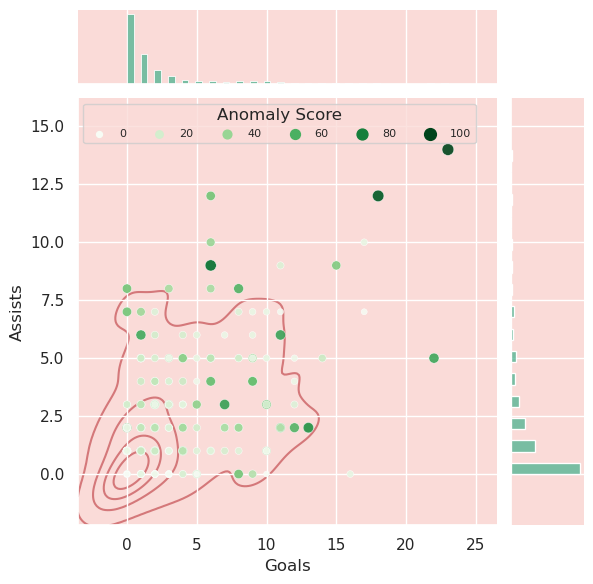

In [27]:
##############################################################################
#Step 3.1. Display traditional anomaly score
# Color map: https://htmlcolorcodes.com/
##318-366
##############################################################################
import seaborn as sns
import matplotlib.pylab as plt
sns.set(rc={'axes.facecolor':'#FADBD8', 'figure.facecolor':'white'})
test_result["Goals"] = RawDataNoEncoding["Goals"] ##No Min-Max, raw data
test_result["Assists"] = RawDataNoEncoding["Assists"] ##No Min-Max, raw data
g = sns.jointplot(data=test_result, x="Goals", y="Assists", color="#4CB391", kind="scatter", alpha=0)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=5, alpha=0.7)
g2 = sns.scatterplot(data=test_result, x="Goals", y="Assists", size="Anomaly Score", hue="Anomaly Score", palette = "Greens", legend=True, alpha=0.9)
g2.legend(loc='upper left', ncol=6, title="Anomaly Score", fontsize=8)


0 Harry Kane
1 Bruno Fernandes
2 Raphael Dias Belloli
3 Alexandre Lacazette
4 Richarlison
5 Matheus Pereira
6 Mohamed Salah
7 Saïd Benrahma
8 Jack Harrison
9 Kelechi Iheanacho
10 Jesse Lingard
11 James Rodríguez
12 Gareth Bale
13 Edinson Cavani
14 Aaron Cresswell
15 Kevin De Bruyne
16 Cengiz Ünder
17 Lucas Digne
18 Joe Willock
19 Jamie Vardy
20 Sergio Agüero
21 Bukayo Saka
22 Stuart Armstrong
23 Harvey Barnes
24 Serge Aurier
25 Mateusz Klich
26 İlkay Gündoğan
27 Jack Grealish
28 Phil Foden
29 Hélder Costa


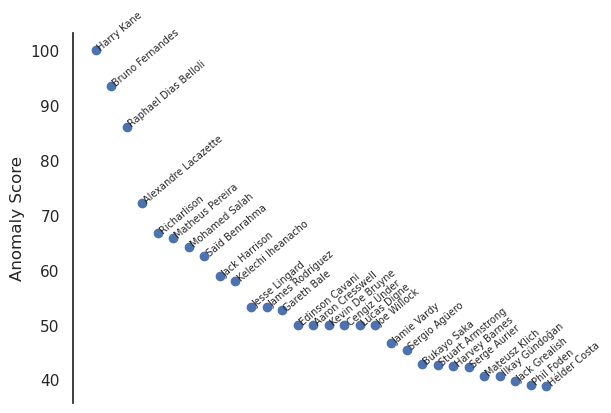

In [28]:
##############################################################################
#Step 3.2. Display Anomaly Score List
##############################################################################
sns.set(style='white')

test_result = test_result.sort_values(by=['weight_score'], ascending=False)

test_result_head = test_result.head(30)

test_result_head["index"] = range(30)

y = list(test_result_head["weight_score"])
z = list(test_result_head["index"])
n = list(test_result_head["Name"])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.scatter(z, y)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Anomaly Score')

for i, txt in enumerate(n):
    print(i, txt)
    ax.annotate(txt, (z[i], y[i]), rotation=40, fontsize=7)


In [33]:
##############################################################################
# Step 3.3. Define a function to explain an anomaly
##############################################################################

def AnomalyExplain(query_index,
                   dist_matrix,
                   num_neighbours,
                   RawData,
                   RawDataNoEncoding,
                   AllCols,
                   ContexCols,
                   BehaveCols):
    """

    Parameters
    ----------
    query_index : int
        the index of query object.
    dist_matrix : dataframe
        Gower's distance matrix between all objects.
    num_neighbours : int
        the number of neighbours.
    RawData : dataframe
        dataframe containing all objects after preprocessing.
    RawDataNoEncoding : dataframe
        dataframe containing all objects before preprocessing..
    AllCols : list
        list containing all feature names.
    ContexCols : list
        list containing all contextual feature names..
    BehaveCols : list
        list containing all behavioural feature names..

    Returns
    -------
    None

    """
    # ==================================================================
    ##Step F1. find k contextual neighbours and show their distribution
    # ==================================================================
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pandas.api.types import is_string_dtype
    plt.style.use('default')  ##to unify style

    ##This one is easy but not flexible 
    # sns.set_style("white")
    # dist_vec = np.array(dist_matrix[str(query_index)])
    # index_vec = list(np.argsort(dist_vec)[:num_neighbours+1])
    # neighbour_data = RawData.loc[index_vec]
    # neighbour_con = RawDataNoEncoding[ContexCols].loc[index_vec]
    # neighbour_con_long = pd.melt(neighbour_con, var_name="contextual feature")
    # g = sns.FacetGrid(neighbour_con_long, col="contextual feature", col_wrap=3, sharex=False)
    # g.map(plt.hist, "value", alpha=0.4, color="r")

    ##This one is more flexible 
    sns.set_style("white")
    dist_vec = np.array(dist_matrix[str(query_index)])
    index_vec = list(np.argsort(dist_vec)[:num_neighbours+1])
    neighbour_data = RawData.loc[index_vec]
    neighbour_rawdata = RawDataNoEncoding.loc[index_vec]
    # neighbour_rawdata = neighbour_data.copy()
    plt.figure()
    for con_col in range(0,len(ContexCols),1):
        ax = plt.subplot(1,len(ContexCols),con_col+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        con_col_name = ContexCols[con_col]
        # ax.set_title(con_col_name)
        ax.set_xlabel(con_col_name)
        ax.set_ylabel("count")

        query_con_value = neighbour_rawdata[con_col_name].loc[query_index]

        if is_string_dtype(neighbour_rawdata[con_col_name]) == True:

            unique_items = set(neighbour_rawdata[con_col_name])

            ##map the target to red, others to green
            ## color_mapping = {'DF': "#FA8072", 'FW': "#00FF7F", 'GK': "#00FF7F", 'MF': "#00FF7F"} 
            color_mapping = {}
            for my_item in unique_items:
                print(query_con_value)
                if query_con_value == my_item:
                    color_mapping[my_item] = "#FA8072"
                else:
                    color_mapping[my_item] = "#00FF7F"

            sns.countplot(x=con_col_name, data=neighbour_rawdata, palette = color_mapping)

        else:
        ##change color of the bin to which the target belongs
            my_n, my_bins, my_patches = plt.hist(neighbour_rawdata[con_col_name], color = "#00FF7F")

            for bin_edge in range(0,len(my_bins)-1):
                if my_bins[bin_edge] <= query_con_value and query_con_value <= my_bins[bin_edge+1]:
                    my_patches[bin_edge].set_fc('#FA8072')
                    print(con_col_name)
                    print(query_con_value)
                    print(query_index)


    # =============================================================================
    # Step F2. Define the beanplot function to explain an anomaly
    # =============================================================================
    def beanplot_variant(col_name, actual_value, quantile_vec, position=0):
        """
        Parameters
        ----------
        col_name : string
            the name of target behavioural feature.
        actual_value : double
            the actual target behavioural feature value.
        quantile_vec : list
            list containing the estimated quantiles based on reference group of the target object.
        position : double, optional
            value used to adjust the position of plot. The default is 0.

        Returns
        -------
        None.

        """

        import matplotlib.pyplot as plt
        ##Paramter 1
        actual_value = actual_value

        ##Paramter 2
        position = position

        ##Paramter 3
        quantile_vec = quantile_vec

        quantile_vec_diff = np.diff(quantile_vec)
        len_interval = 1/len(quantile_vec)
        density_vec = [len_interval/(max(x,0.0005)) for x in quantile_vec_diff]

        # density_vec = [len_interval/x for x in quantile_vec_diff]
        print(np.max(density_vec))
        print(np.max(density_vec))


        len_mark = np.max(density_vec)/2 #length of black line
        len_basic = (np.max(quantile_vec)-np.min(quantile_vec)) #length of blue line 
        len_box = len_basic*6  #length of cyan line 
        density_vec.append(0)

        ##other paramters
        scale_factor = 1
        len_box = len_box*scale_factor
        len_mark = len_mark*scale_factor
        len_basic = len_basic*scale_factor

        plt.ylabel(col_name +" (scaled)")
        plt.xticks([])

        data_to_plot = pd.DataFrame()
        data_to_plot["x_axis"] =  quantile_vec
        data_to_plot["y_axis"] = [x*scale_factor  + position for x in density_vec]
        data_to_plot["z_axis"] = [-x*scale_factor + position for x in density_vec]

        plt.fill(np.append(data_to_plot["y_axis"], data_to_plot["z_axis"][::-1]),
                 np.append(data_to_plot["x_axis"], data_to_plot["x_axis"][::-1]),
                 color='red', alpha=0.6)


        ##Plot basic blue line segments
        for quantile_value in quantile_vec:
            plt.plot([-len_basic+position, len_basic+position], [quantile_value, quantile_value], color="blue")


        ##Plot terget object   
        plt.plot([-len_mark+position,len_mark+position], [actual_value, actual_value], color="black", alpha=1)

        ##Plot quartiles
        q25 = quantile_vec[24]
        q50 = quantile_vec[49]
        q75 = quantile_vec[74]


        plt.plot([-len_box+position, len_box+position], [q25, q25], color="cyan")
        plt.plot([-len_box+position, len_box+position], [q50, q50], color="cyan")
        plt.plot([-len_box+position, len_box+position], [q75, q75], color="cyan")
        plt.plot([-len_box+position, -len_box+position], [q25, q75], color="cyan") #connecting them with a box
        plt.plot([len_box+position, len_box+position], [q25, q75], color="cyan") #connecting them with a box


    # ==================================================================
    ##Step F3. calculate anomaly score using neighbouring data points
    # ==================================================================
    def QRF_score(ReferenceDataSet, MyColList, MyContextList, MyBehaveList, step_width, new_point_index):
        """
        As above
        """

        MyDataSet = ReferenceDataSet[MyColList]
        MyContextDataSet = MyDataSet[MyContextList]
        MyBehaveDataSet = MyDataSet[MyBehaveList]

        def QuantilePerCol(X_train, X_test, y_train, y_test, step_width):
            """
            As above
            
            """

            rfqr = RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=10)


            rfqr.set_params(max_features= X_train.shape[1] // 1)
            rfqr.fit(X_train, y_train)

            quantile_0 = rfqr.predict(X_test, quantiles=[0.001])
            quantile_25 = rfqr.predict(X_test, quantiles=[0.25])
            quantile_75 = rfqr.predict(X_test, quantiles=[0.75])
            quantile_100 = rfqr.predict(X_test, quantiles=[1.0])

            quantile_vec = []
            quantile_location = -1
            scale_factor = (1000/step_width) ##to avoid too samll number in Python
            for quantile_num in np.arange(0,100/step_width,1):

                quantile_num = quantile_num*step_width
                quantile_left = rfqr.predict(X_test, quantiles=[quantile_num/100])
                quantile_right = rfqr.predict(X_test, quantiles=[min(100,quantile_num+step_width)/100])
                quantile_vec.append(quantile_left[0])

                if quantile_left[0] <= y_test.iloc[0,0] and y_test.iloc[0,0] <= quantile_right[0]:
                    quantile_location = int(quantile_num/step_width)

            quantile_vec_diff = np.diff(quantile_vec)
            quantile_vec_diff_rank = [sorted(quantile_vec_diff).index(x) for x in quantile_vec_diff]

            if (quantile_location == -1) and (y_test.iloc[0,0] < quantile_0):

                result_temp = (1+abs(y_test.iloc[0,0]-quantile_0)/(quantile_75-quantile_25))*np.max(quantile_vec_diff)

                quantile_diff =  result_temp[0]*scale_factor
                quantile_rank = 120
                print("A")
                return quantile_location, quantile_diff, quantile_rank, quantile_vec

            elif (quantile_location == -1) and (y_test.iloc[0,0] > quantile_100):
                normal_int_len = max(0.000000001,quantile_75-quantile_25)
                result_temp = (1+abs(y_test.iloc[0,0]-quantile_100)/normal_int_len)*np.max(quantile_vec_diff)

                quantile_diff =  result_temp[0]*scale_factor
                quantile_rank = 120
                print("B")
                return quantile_location, quantile_diff, quantile_rank, quantile_vec

            quantile_diff = quantile_vec_diff[quantile_location-1]*scale_factor
            quantile_rank = quantile_vec_diff_rank[quantile_location-1]
            print("C")

            return  quantile_location, quantile_diff, quantile_rank, quantile_vec



        X_train = MyContextDataSet[~MyContextDataSet.index.isin([new_point_index])]
        X_test = MyContextDataSet[MyContextDataSet.index.isin([new_point_index])]
        y_train_raw = MyBehaveDataSet[~MyBehaveDataSet.index.isin([new_point_index])]
        y_test_raw = MyBehaveDataSet[MyBehaveDataSet.index.isin([new_point_index])]

        quantile_bahave = []
        quantile_vec_all = {}

        for behave_col in MyBehaveList:
            y_train = y_train_raw[[behave_col]]
            y_test = y_test_raw[[behave_col]]

            quantille_result, quantille_result_diff, quantille_result_diff_rank, quantile_vec = QuantilePerCol(X_train, X_test, y_train, y_test, step_width)
            quantile_score = quantille_result_diff
            quantile_bahave.append(quantile_score)

            quantile_vec_all[behave_col] = quantile_vec

        anomaly_behave = quantile_bahave.copy()

        return anomaly_behave, quantile_vec_all
    #execute our algorithm  
    print("-----------------------------")
    print("query object index: " + str(query_index))
    print("-----------------------------")
    Filter_df =  neighbour_data
    MyColList =  AllCols
    MyContextList = ContexCols
    MyBehaveList = BehaveCols
    step_width = 1
    new_point_index = query_index

    ##get raw quantiles for each behaviral column             
    quantile_anomaly_score, quantile_dict = QRF_score(Filter_df, MyColList, MyContextList, MyBehaveList, step_width, new_point_index)
    print(quantile_anomaly_score)

    # ==================================================================
    ##Step F4. display raw anomaly scores in each behaviroual feature using beanplot variant in descending order
    # ==================================================================

    plt.figure()

    for behave_col in range(0,len(BehaveCols),1):
        print(behave_col)
        ax = plt.subplot(1,len(BehaveCols),behave_col+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        behave_col_name = BehaveCols[behave_col]
        beanplot_variant(behave_col_name, neighbour_data[behave_col_name].loc[query_index], quantile_dict[behave_col_name])



MF
MF
MF
MF
FW
FW
FW
FW
Age
24
478
Matches
33
478
Starts
30
478
Mins
2577
478
-----------------------------
query object index: 478
-----------------------------
B
C
[26.08695652173939, 12.857142857142566]
0
20.0
20.0
1
20.0
20.0


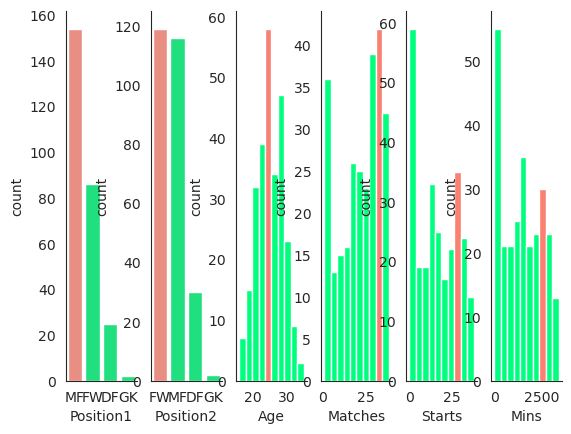

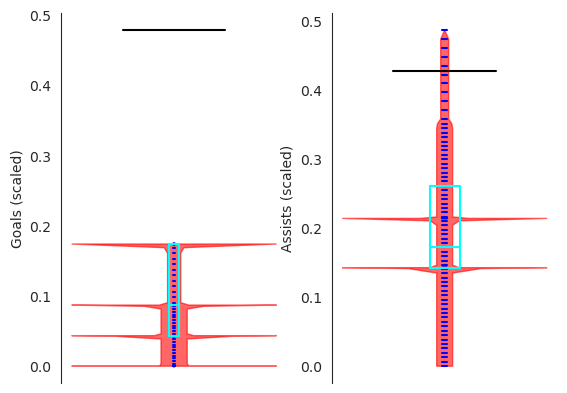

In [34]:
##############################################################################
##Example:  test index 478
##############################################################################
test_df = AnomalyExplain(478,
                         dist_mat_df,
                         266,
                         RawDataSet, 
                         RawDataNoEncoding,
                         MyColList,
                         MyContextList,
                         MyBehaveList)
